# DataCamp Certification Case Study

### Project Brief

You have been hired as a data scientist at Discount Motors, a used car dealership in the UK. The dealership is expanding and has hired a large number of junior salespeople. Although promising, these junior employees have difficulties pricing used cars that arrive at the dealership. Sales have declined 18% in recent months, and management would like your help designing a tool to assist these junior employees.

To start with, they would like you to work with the Toyota specialist to test your idea(s). They have collected some data from other retailers on the price that a range of Toyota cars were listed at. It is known that cars that are more than £1500 above the estimated price will not sell. The sales team wants to know whether you can make predictions within this range.

You will need to present your findings in two formats:
- You must submit a written report summarising your analysis to your manager. As a data science manager, your manager has a strong technical background and wants to understand what you have done and why. 
- You will then need to share your findings with the head of sales in a 10 minute presentation. The head of sales has no data science background but is familiar with basic data related terminology. 

The data you will use for this analysis can be accessed here: `"data/toyota.csv"`

# Project Description
As a Data Scientist at Discount Motors in the UK, I received a new project with the goal of supporting sales employees with the **pricing** of used cars, specifically for Toyota cars. 

From a business perspective, the objective is clear: to create the first version of predictive model, in an employee can enter specifications of a used car or submit new samples of car-ata and a the tool will automatically try to predict a price. The predicted price can assist the sales employees in making a more informed decision. Furthermore, the predictive model could - in the future - become part of an assitance tool, where an employee can enter some car data and get a price suggestion. As a top requierement, the estimated price from the tool, should not exceed £1500 the market price, otherwise cars will not sell. On the other hand, the price cannot be too low, or the profits per saled car will decrease.

From a technical perspective, the project can be described as follows:
- A dataset containing historic used car features (independent variables) and their sales price is available
	- In it, each row describes eight characteristics of a sold car
    - our **goal** is to try to predict the sales price, given these features
- We will use two performance-measures:
	- techincal metric: our predictive models are evaluated using the Root-Mean-Squared-Error (RMSE) between the predicted sales price and the actual historic sales price
    - business metric: in absolute terms, the predicted price, shall not exceed the actual price by 1500 GBP

# Technical Report
## Approach
The technical approach to this project, will follow a series of steps:

	1. Explore the data
    2. Prepare (feature selection) and clean the data
    3. Model training and evaluation
    5. Results and future work

## Before we start...
For better readability, we will import and thus provide an overview of all needed modules in one place:

In [1]:
# Basics
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Set standard style and colors for seaborn visualizations
sns.set_style("white")
sns.set_color_codes(palette='pastel')

# Data preparation
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew
from scipy.stats import yeojohnson

# Model related
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Model evaluation
from sklearn.metrics import mean_squared_error

#### Train, Test Samples
Also, as is best practice in machine learning projects, we will split our raw data in `/data/toyota.csv` into a train and test samples so as to not bias our data analysis work. We will use the conventional function `train_test_split()`, with a test size of 30%.

In [2]:
# Import the data and visualize it
df = pd.read_csv('data/toyota.csv')

print(f"The raw data has {df.shape[1]} columns and {df.shape[0]} rows")
df.head(2)

The raw data has 9 columns and 6738 rows


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0


As we can see the import worked successfully, with all nine columns.
Furthermore, since the data contains 6738 rows, i.e. not that small of a dataset, a test size of 30% of the data is a valid choice.

In [3]:
# Split independent variables (X) and dependent variable (y, here price)
y = df["price"]
X = df.drop(columns=["price"])

# Split data into test and train samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Validate split
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(4716, 8) (4716,) (2022, 8) (2022,)


## 1. Exploratory Data Analysis

### price - the variable want to predict
As we saw above, the price variable is of numeric type, so we visualize accordingly it with proper methods.

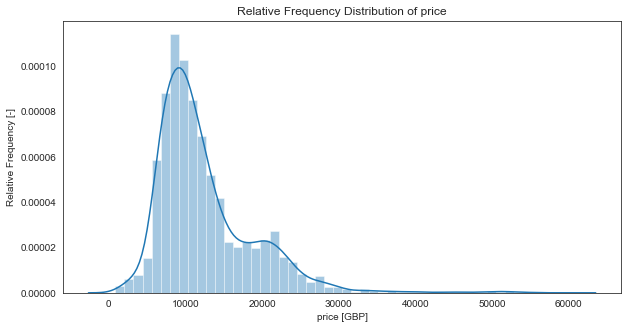

In [4]:
# Check the distribution 
f, ax = plt.subplots(figsize=(10, 5))
sns.distplot(y_train);
ax.set(title='Relative Frequency Distribution of price', xlabel="price [GBP]", ylabel="Relative Frequency [-]")
plt.show()

We can already gain some insights from this plot regarding the price variable:

- I1: The dependent variable price is strongly skewed to the right, meaning most of its data is contained to the right of the peak of the curve. Many predictive models do not work well with skewed data, but work best with normally distributed data.
- I2: There appear to be a few very large values that give the curve its long tail to the right. This is an indicator for outliers in the price.

We will address both of this insights in the next section.

### Rest of the attributes
For a proper data exploration, we will separate the numeric attributes from the categorical ones. We know from the description of the data which attributes ought to be of which type, but just to double check:

In [5]:
X_train.dtypes

model            object
year              int64
transmission     object
mileage           int64
fuelType         object
tax               int64
mpg             float64
engineSize      float64
dtype: object

In [6]:
categ_attr = ['model', 'transmission', 'fuelType']
numer_attr = ['year', 'mileage', 'tax', 'mpg', 'engineSize']

#### Categorical attributes
We will check the value distribution of each of the categorical values. This we will do for the whole dataset, not only for the train dataset.

In [7]:
df[categ_attr[0]].value_counts(dropna=False)

 Yaris            2122
 Aygo             1961
 Auris             712
 C-HR              479
 RAV4              473
 Corolla           267
 Prius             232
 Avensis           115
 Verso             114
 Hilux              86
 GT86               73
 Land Cruiser       51
 PROACE VERSO       15
 Supra              12
 Camry              11
 IQ                  8
 Urban Cruiser       4
 Verso-S             3
Name: model, dtype: int64

In [8]:
df[categ_attr[1]].value_counts(dropna=False)

Manual       3826
Automatic    2657
Semi-Auto     254
Other           1
Name: transmission, dtype: int64

In [9]:
df[categ_attr[2]].value_counts(dropna=False)

Petrol    4087
Hybrid    2043
Diesel     503
Other      105
Name: fuelType, dtype: int64

We learned from this results:

- I3. That none of the categorical attributes have missing values (across the whole dataset) and
- I4. that they are not uniformally distributed. There are a couple of values that tend to have larger frequencies than the rest. Furthermore, almost all entries have intuitive or interpretable values for the sales employees. The only value, which does not contain much intrinsic information is "Other" in the "fuelType" attribute. So in general, this attributes are technically also going to be important for our models. We deal with their categorical (i.e. not-numerical) nature in the next section

#### Numerical attributes
Let's study the numerical attributes, their characteristics and also the mathematical relations between each other. Let's start by checking for missing values.

In [10]:
for x in numer_attr:
    print(x , ' has so many missing values:' , df[x].isnull().sum())

year  has so many missing values: 0
mileage  has so many missing values: 0
tax  has so many missing values: 0
mpg  has so many missing values: 0
engineSize  has so many missing values: 0


- I5. As we can see, there are no missing values across any columns of the entire dataset. This is important, since it allows us to use the entire dataset for training and testing the model, without having to delete any rows/samples or withoug artifically filling missing information.

We follow our exploratory analysis of numerical attributes with a scatter matrix using only the training data:

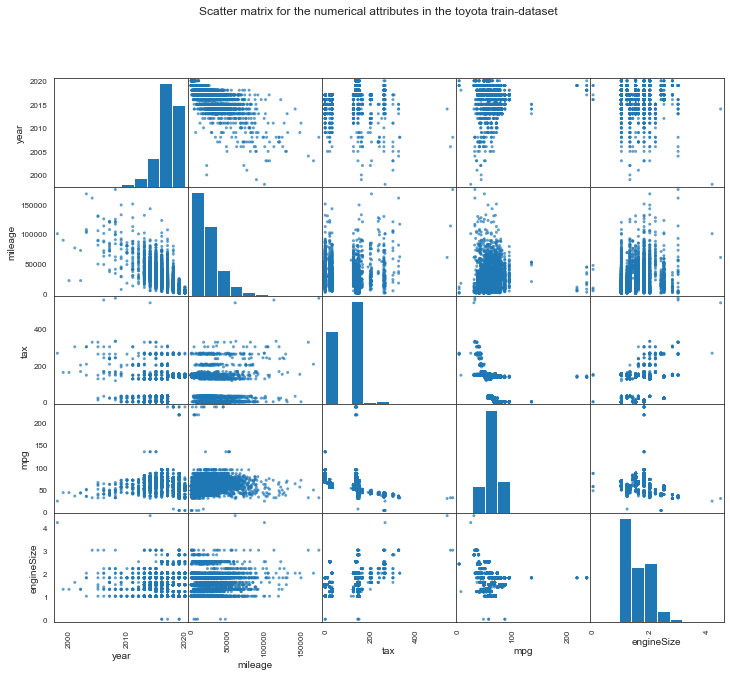

In [11]:
pd.plotting.scatter_matrix(X_train[numer_attr], figsize=(12, 10), alpha=0.7, diagonal='hist')
plt.suptitle('Scatter matrix for the numerical attributes in the toyota train-dataset')
plt.show()

The scatter matrix presents two types of information on a fairly compact way:

1. on the diagonal we see a histogram (i.e. an approximate frequency distribution) for each of the variables
2. on left-down side from the diagonal, the numerical relationship from two different variables, is respectively shown. For example, on the most left and bottom graph, we see the relationship between the `engineSize` and the `year`. The right-top side over the diagonal shows the same information but with mirrored axes.

From this understanding and loooking at each chart, we can extract some valuable insights from the data, starting with the **histograms on the diagonal**:

- I6. The `year`, `mileage` and `engineSize` appear to have a skewed distribution, i.e. do not appear to be normally distributed. As with the variable to predict `price`, this is something we will have to address later
- I7. The `tax` and `mpg`, counterituively, appear to have certain specific brackets of values instead of a continuous distribution. However, looking at the third (`tax`) and fourth (`mpg`) column, we see that their values are more spread than the histogram suggests. Furthermore, both mpg and the tax in GB-pounds are intuitevely numeric, meaning that a higher or lower value has an intuitive impact on a higher or lower car price.

Form the **scatter plots** here it becomes clear that some attributes correlate with each other, while others do not:

- I8. The `year` and `mileage` seem to correlate negatively, that is the higher the year the lower the mileage. This corresponds to intuition, since older cars have had more time to be driven. Other than that both attributes seem to have no correlation with the rest of the attributes whatsoever.
- I9. Between `mpg`, `tax` and `engineSize` appears to be a slight correlation, which would also follow intuition, since a larger engine size affects the mpg and the emissions, from which the tax is deducted. We will explore this further, since it is hard to see in the plot above.

In [12]:
# Correlation coefficient between year and mileage
corr = X_train[['year', 'mileage']].corr()
display(corr)

# Correlation coefficient between the rest
corr = X_train[['tax', 'mpg', 'engineSize']].corr()
display(corr)

,year,mileage
year,1.000000,-0.727149
mileage,-0.727149,1.000000


,tax,mpg,engineSize
tax,1.000000,-0.427509,0.144114
mpg,-0.427509,1.000000,-0.104026
engineSize,0.144114,-0.104026,1.000000


What can we learn from this correlation matrix?
- We can confirm our eigth insight (I8), that is `year` and `mileage` do have a strong negative correlation, the newer the car (higher the year number) the less the expected mileage of a used car. Even tough, they seem to correlate strongly, we will check later if this is the case after the transformation. Regardless, we do not think it is necessary to remove one of the attributes, since in a business sense, both informations are very relevant for both sales employees and prospective buyers
- From the rest of the three relationship, only the `tax` and the `mpg` appear to have a weak negative correlation

### price and the rest of the attributes
Now that we have taken a separate look at the bivariate relationship between price and the rest of the attributes, and see if there are already some type of correlation that we can observe.

#### price and the categorical attributes
For this part, we will create a separate box-plot between `price` (numerical) and all three categorical variables `model`, `transmission` and `fuelType`

[Text(0, 0.5, 'price [GBP]')]

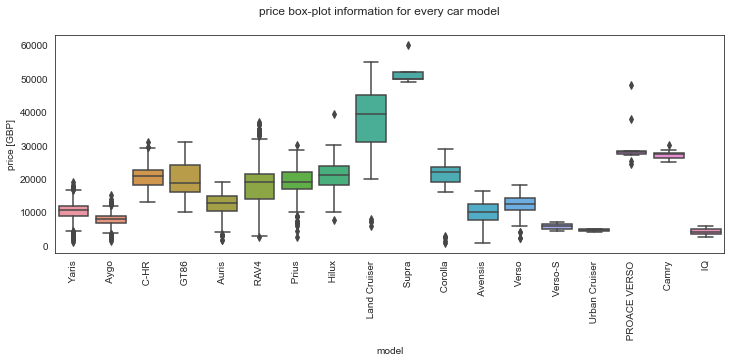

In [13]:
data_train = pd.concat([y_train, X_train], axis=1)

f, ax = plt.subplots(figsize=(12, 4))
fig = sns.boxplot(x='model', y="price", data=data_train)
plt.suptitle('price box-plot information for every car model')
plt.xticks(rotation=90);
ax.set(ylabel='price [GBP]')

[Text(16.200000000000003, 0.5, 'price [GBP]')]

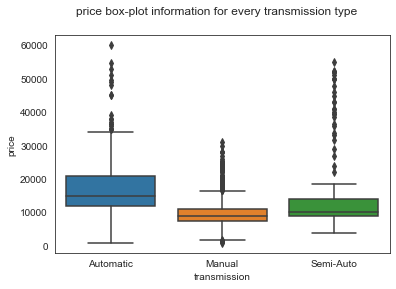

In [14]:
sns.boxplot(x='transmission', y="price", data=data_train)
plt.suptitle('price box-plot information for every transmission type')
ax.set(ylabel='price [GBP]')

[Text(16.200000000000003, 0.5, 'price [GBP]')]

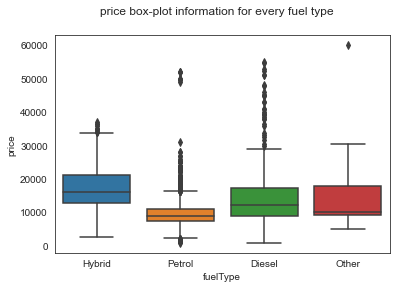

In [15]:
sns.boxplot(x='fuelType', y="price", data=data_train)
plt.suptitle('price box-plot information for every fuel type')
ax.set(ylabel='price [GBP]')

I10. From the box-plots we can see that the different values in all three categories have an impact on the price. On the `model`, the variance is a bit more clear, where for example the price range between a Toyota Aygo and a Toyota Supra do not even overlap. In the other two attributes is less obvious, but also visible. In transmission, there is a clear difference price difference between automatic and manual transmission types, whereas with fuel type the larger difference appears to be between petrol and hybrid cars.

#### price and the numerical attributes
Here we will start backwards. First the correlation coefficients and then the scatter plots.

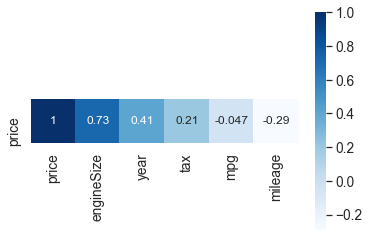

In [16]:
# Create a heatmap with correlation coefficients
cols = [*numer_attr, 'price']
corrmat = data_train[cols].corr()
sns.set(font_scale=1.25)
hm = sns.heatmap(corrmat[['price']].sort_values('price', ascending=False).T, annot=True, square=True,  annot_kws={'size': 12}, cmap="Blues")

We are most interested in the extreme values (most to the left or most to the right in the heatmap). As we can see, the engine size has the highest correlation with the variable we are trying to predict, followed by year and then by mileage (the latter negatively correlated). We have to bear in mind, that both year and mileage showed a high skewdness, which - before accounting for that - might show lower correlation values.

We will use this information and take a closer look at all three relations:

<AxesSubplot:xlabel='engineSize', ylabel='price'>

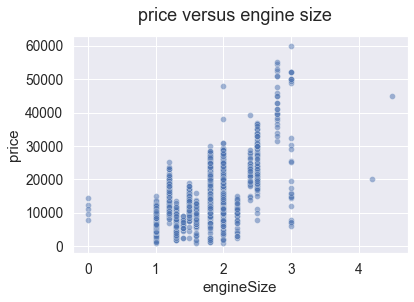

In [17]:
plt.suptitle('price versus engine size')
sns.scatterplot(x='engineSize', y='price', data=data_train, alpha=0.5)

The graph is spread out a bit, but it does look like in general a higher engine size comes with a higher price tag.

<AxesSubplot:xlabel='year', ylabel='price'>

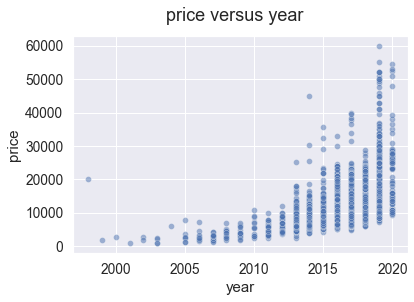

In [18]:
plt.suptitle('price versus year')
sns.scatterplot(x='year', y='price', data=data_train, alpha=0.5)

From the two scatter graphs above, both engine size and year seem to show categorical characteristics, that is they appear to be more discrete numeric variables, than continuous.

- For the engine size it does not make much sense to treat is a categorical variable, since it is a measurable quantity and the mean between two given values does tells us valid information
- I11. For the year, it might be worth to treat its information as categorical, since it is not a continuosly measurable quantity and the mean of any two given years does not provide much information. How old a car is (hint: new feature), that might be a possible solution. We will explore this further in the next section. Plotting a boxplot for the year, might still help us find out, if the year has some kind of impact on price.

<AxesSubplot:xlabel='year', ylabel='price'>

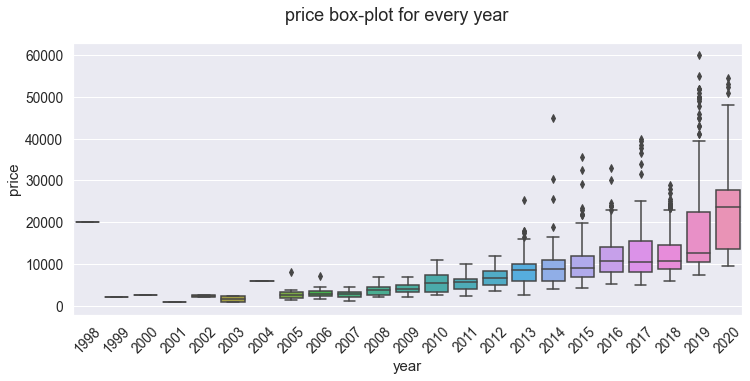

In [19]:
f, ax = plt.subplots(figsize=(12, 5))
plt.xticks(rotation=45);
plt.suptitle('price box-plot for every year')
sns.boxplot(x='year', y="price", data=data_train)

Indeed, with the exception of very old cars that can be treated as *'classical / old timers'* cars, it appears the newer the car, the higher the average price

<AxesSubplot:xlabel='mileage', ylabel='price'>

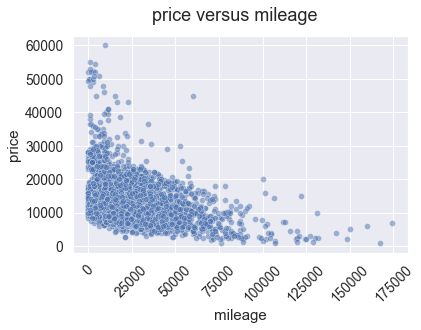

In [20]:
plt.xticks(rotation=45);
plt.suptitle('price versus mileage')
sns.scatterplot(x='mileage', y='price', data=data_train, alpha=0.5)

## 2. Clean and prepare the data
In the past section, we gained some insights into how the data can be cleaned and prepared before modeling. We learned, for example, that the data does not contain any missing values, so that no filling / deleting must be made. We also took around eleven different insights (marked above with 'IX.'), which we will address in this section. However, since we are going to make some transformations and preparations, we will join the train and test data to apply this transformations equally to all samples:

In [21]:
train = pd.concat([X_train, y_train], axis=1)
train["sample_type"] = "train"

test = pd.concat([pd.DataFrame(X_test), y_test], axis=1)
test["sample_type"] = "test"

full_data = pd.concat([train, test], axis=0)
# Validate the join
print(full_data[full_data.sample_type == "train"].shape[0] == X_train.shape[0])
print(full_data[full_data.sample_type == "test"].shape[0] == X_test.shape[0])

True
True


Now let's go over the insights and perform some preparations of the full data before modeling.

In [22]:
# I1. Check the skewdness of the dependent variable 'price'
print(f"The initial skewdness of price: {full_data['price'].skew()}")

The initial skewdness of price: 1.8167427530241371


As seen in the exploratory data analysis, the price variable is a bit skewed. We could apply a transformation to approach a normal or gaussian distribution. This might lead to more accurate predictions of price, however we would lose interpretability and usability of the price variable - tough a reverse transformation is possible. But for the scope of the project, we will desist of transforming the price variable.

Regarding I2.: after some consideration, we won't remove any possible statistical outliers from the price sample for three reasons:

1. The largest and lowest values of price are realistic values for used cars
2. Removing the highest and lowest, could make our model more robust, but also 'unprepared' for such values, that are in any case, very likely to come again in the market
3. The sample data is not huge, so any valid and complete sample we can get is helpful

Insights I3., I5. and I7. are more informative than actionable (no missing values).

I4. talks about the nature of the categorical variables. We will hot encode categorical features as number-categories, such that the models we are going to try and use, can "digest" this attributes as well. This we will do at the end of this section.

Insight I6. refers to the apparent skewdness of `year`, `mileage` and `engineSize`. We will spear year from any transformation, since it is not strictly continuous and will make only harder to interpret its results. What would, e.g., the logarithm of a year mean?

`mileage` and `engineSize` are measurable and continuous in nature, so that a transformation is not as problematic. But let's check their initial skewdness first:

In [23]:
print(f"The initial skewdness of mileage   : {full_data['mileage'].skew()}")
print(f"The initial skewdness of engineSize: {full_data['engineSize'].skew()}")

The initial skewdness of mileage   : 1.9009175649564012
The initial skewdness of engineSize: 0.8382124586602858


Both distribution appear to be somewhat skewed with a value higher than 0.5. Since both only contain positive values, we will use the yeo-johnson transformation as well.

In [24]:
yf_target_m, lam = yeojohnson(full_data["mileage"])
yf_target_e, lam = yeojohnson(full_data["engineSize"])

full_data["mileage"] = yf_target_m
full_data["engineSize"] = yf_target_e

print(f"The skewdness of mileage after the yeo-johnson transformation is    :{skew(yf_target_m)}")
print(f"The skewdness of engineSize after the yeo-johnson transformation is :{skew(yf_target_e)}")

# Let's validate that the variables have been transformed
full_data.head(2)

The skewdness of mileage after the yeo-johnson transformation is    :0.006728993008168798
The skewdness of engineSize after the yeo-johnson transformation is :-0.02062907594809522


,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price,sample_type
2364,Yaris,2019,Automatic,94.573895,Hybrid,135,76.3,0.708196,14516,train
944,Yaris,2017,Automatic,106.870205,Hybrid,0,78.0,0.708196,12498,train


Insights I8 and I9 hint of correlations between the numerical attributes. This could be the starting point of some feature creation, decorrelation or dimensionality reduction. However, we won't use any of these techniques as of now:

- to keep the model simple and understandable
- the numerical attributes to our disposal, are all business-relevant and they are not that numerous (five). So deleting any of these would result in some loss of information for the model, specially for different data samples that the model has not been trained on, e.g. cars from different brands other than Toyota.

The result from I10 is that we ought to use all three categorical variables in our model.

Regarding I11, we discussed shortly beforehand, the possibility of transforming or using the information `year` in some useful way for the model. An idea would be, for example, to create a new feature called "car_age". The idea and its possible benefits are discussed in the last section of future work.  

The only remaining task we have is from the fourth insight, which is to encode the categorical attributes for the models to be able to digest:

In [25]:
full_data_final_prep = pd.get_dummies(full_data)
full_data_final_prep.head()

,year,mileage,tax,mpg,engineSize,price,model_ Auris,model_ Avensis,model_ Aygo,model_ C-HR,...,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,sample_type_test,sample_type_train
2364,2019,94.573895,135,76.3,0.708196,14516,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
944,2017,106.870205,0,78.0,0.708196,12498,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
5354,2016,102.209512,0,69.0,0.569150,6950,0,0,1,0,...,0,1,0,0,0,0,0,1,0,1
5818,2017,104.549437,145,47.1,0.630781,17695,0,0,0,1,...,0,1,0,0,0,0,0,1,0,1
5563,2020,24.048306,145,56.5,0.569150,11500,0,0,1,0,...,0,1,0,0,0,0,0,1,0,1


Finally, for this section we will split the samples into train and test, according to the original split.

In [26]:
train_final = full_data_final_prep[full_data_final_prep.sample_type_train == 1]
y_train_final = train_final["price"]
X_train_final = train_final.drop(columns=["price", "sample_type_train", "sample_type_test"])

test_final = full_data_final_prep[full_data_final_prep.sample_type_test == 1]
y_test_final = test_final["price"]
X_test_final = test_final.drop(columns=["price", "sample_type_train", "sample_type_test"])

# Validate resplitting
print(f"y_train shape {y_train_final.shape}, X_train shape {X_train_final.shape}")
print(f"y_test shape {y_test_final.shape}, X_test shape {X_test_final.shape}")

y_train shape (4716,), X_train shape (4716, 31)
y_test shape (2022,), X_test shape (2022, 31)


## 3. Model training and evaluation

The problem we are trying to solve here can be categorized as Multivariate Regression. We have multiple variables (characteristics from a used car) that affect a given numeric variable (the price of the used car). There are multiple advanced models for this type of problem. However, taking into account the scope of this project, the project clients and the relative small size of the data, we will keep it simple and use a relative simple model, that - in case it became necessary - could also be explained to our business partners, including our sales employees and managers.

The approach we will use will be a Linear Regression. Let's start by initializing the model, fitting it to our prepared data:

In [27]:
# Create and fit the model
reg = LinearRegression()
reg.fit(X_train_final, y_train_final)

LinearRegression()

Let's follow up with predicting the prices for our test data. We will use the model's built-in score function to get a sense of the model's performance:

In [28]:
# Predict on the test data
y_predicted = reg.predict(X_test_final)

# Calculate the score between predicted and real prices
reg.score(X_test_final, y_test_final)

0.9288533823087788

The score from the linear regression has a minimal and maximal possible value of 0 and 1, respectively. A value of aprrox. 0.93 is a very good score for a relative simple model. This is almost too good, to be true, so as mentioned in the project description, will do to further checks to evaluate our model:

1. Technical metric: we will use the Root-Mean-Square-Error (rsme) measure as a further score of the model
2. Business metric: we will check if and how many predicted prices are 1500 GBP above the real prices for the test set

In [29]:
# 1. Calculate the Root-Mean-Square-Error (rmse)
print(f"The rsme is: {np.sqrt(mean_squared_error(y_test_final, y_predicted))}")

print(f"Extra info: the mean of the real prices in the test dataset is: {y_test_final.mean()}")

The rsme is: 1688.1611445305812
Extra info: the mean of the real prices in the test dataset is: 12653.373392680514


In a simple sense, the rmse can be interpreted as the average distance between the observed price values and the predicted price values. For used cars that sell in an average of 12300 GBP, an average predictive distance of 1600 GBP is not a great sign. Specially, given the business limit of 1500 GBP. If the value of the cars is more than 1500 GBP above the 'real' value, than cars will not be bought, and if they are 1500 GBP under it, then the cars will be sold too cheaply. This is a more realistic and rather negative assesment of our current (albeit first version) model, in comparison to the score of 0.92 above.

Let's now check our business metric, and count the percentage of predictions, where the predicted value was as much or more than 1500 GBP above the real value.

In [30]:
price_diff = abs(y_test_final - y_predicted)

amount_above = price_diff[price_diff >= 1500]
percent = (amount_above.shape[0]/price_diff.shape[0])

print(f"The percentage of predicted values with a price of 1500 GBP above the real price is: {percent*100} %")

The percentage of predicted values with a price of 1500 GBP above the real price is: 22.997032640949556 %


Almost a quarter of the predictions where above the no-go threshold set by the business problem at hand. This simple calculation further confirms our previous findings, that the current predictive model does not yet meet the best standards for the sales employees.

## 4. Results and future work
Our goal for this project was clear, create the first version of a predictive price model for used car data, specifically for Toyota cars. In this broad sense, we can say that we have achieved our goal. The users for this predictive model are sales employees that need assistance on pricing for incoming used cars. The first version of the predictive model we present here, is fairly simple to use and fairly easy to interpret. It can be used as a basis for a future tool, where an employee enters basic used car information and the model gives a preditive price as a result. The approach was also documented and is transparent, such that it should and can be improved with either new data, more business knowledge or further data-specific techniques (with the help of a data analyst / scientist). It is also scalable, in the sense, that when the model reaches a satisfactory usefulness for the business, the code can be used in many dealerships and not only one. However, in its current state, the model is not ready for sales employees to blindly enter data from any used car and get a reliable, robust and consistent suggestion, with which to use in their own sales processes. 

#### Critic, self-evaluation and future work:
In its current state, the pricing model achieves the overall business goal, but - in our opinion - it does not meet the performance requirements:

- Getting around 25% of the predictions so high, means that the sales employees would have a hard time differentiating the 'bad' predictions from the rest. This percentage has to be brought down to a lower one-digit number, in order to create confidence in the dealerships and incentivize the usage of the price model.
- The rsme also indicates that the predictive prices are too distant - on average - to the real prices. Even without the 1500 GBP, threshold an average distance of 1688 GBP is still to high. This will result - in its current state - in a low usage of the model and thus a low impact
- Another risk of the current state of the model is that it might be strongly biased towards Toyota data and cars, since it was all it was trained for. This also reduces the impact and applicability of the model on cars of other brands and thus its current potential impact on Discount Motor dealerships
- Interestingly tough, the model achieves a relatively high technical score. We interpret this as an indicator that we are in the right direction and need to evolve and fine tune the model. To tackle the problems mentioned above and generally to improve the model, we have some ideas and possible suggestions:
    - Understand where the higher variances are coming from. Further work, should first check where the larger differences between predictive and real prices are - for the current model - and try to find patterns that can be useful to feedback-loop into the development of the model
    - The high technical score from the linear regression might be because of overfitting. Getting more data (quantity) as well as more diverse data (from different brands and different attributes) might help overcome this, as well as to make the model more robust and general. In case there is more data, cross-validation might also be worth to try and reduce overfitting.
    - Prepare the data even more. We saw some possibilities to transform and normalize the price variable. This could initially make the results less interpretable but could lead to a more precise model
    - Feature engineering (creation and selection), e.g.
        - Multiply or combine the correlated features
        - Decorrelate attributes or remove some features through dimensionality reduction techniques
        - Create new features, such as "car_age": Where a year and the mean of a year are hard to interpret for humans, the age of a car is more intuitive to calculate with and its mean makes more sense (a car can be one and a half years old). Such a feature could be useful for the model, since it could 'behave' more numeric than the 'year' and at the same time it would make the variable and its relationship with price easier to interpret

### References
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score

https://towardsdatascience.com/what-is-cross-validation-60c01f9d9e75

https://www.statology.org/how-to-interpret-rmse/y

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html

https://www.quora.com/What-does-positive-and-negative-skew-mean